In [1]:
from NNModel import MultiLayerNN
import numpy as np
import pickle
import torch
import torch.nn as nn
from prep_data import prep_data
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Data Prep

In [2]:
train_loader, test_loader = prep_data()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
state_dict = torch.load("../data/model.pt", weights_only=True)
new_dict = {}
#When model compiles, all weights are modified from LAYERNAME to _orig_model.LAYERNAME. We remove the _orig_model. for compatibility
for k in state_dict.keys():
    new_dict[k[10:]] = state_dict[k]
model = MultiLayerNN(latent_size=128, num_layers=3)
model.load_state_dict(new_dict)
model.to(device)
with open("../data/incorrect_preds.pkl", "rb") as f:
    incorrect_preds = pickle.load(f)
incorrect_imgs = torch.tensor(np.stack([img for img, *_ in incorrect_preds]))
incorrect_imgs.to(device)
pred_classes = torch.tensor([label for _, label, _ in incorrect_preds]).to(device)
true_classes = torch.tensor([label for _, _, label in incorrect_preds]).to(device)

In [3]:
images = []
true_labels = []
for loader in [train_loader, test_loader]:
    for img, lbl in loader:
        images.append(img)
        true_labels.append(lbl)
images = torch.cat(images).reshape(-1, 28*28).to(device)
true_labels = torch.cat(true_labels).to(device)

In [4]:
# Dictionary to store the activations
activations = {}
# Dictionary to store layer names for plotting titles
layer_names = {}

def get_activation(name):
    """Hook function to save the output of a layer"""
    def hook(model, input, output):
        # We detach the output tensor to prevent saving the whole computation graph
        activations[name] = output.detach()
    return hook

# Register a forward hook for each linear layer
# We capture the output of the Linear layer *before* it goes into ReLU
hook_handles = []
layer_id = 0

# Hook for the first linear layer
layer_name = f"Layer {layer_id}: Dim Reduction"
handle = model.dim_reduction.register_forward_hook(get_activation(layer_name))
hook_handles.append(handle)
layer_names[layer_id] = layer_name
layer_id += 1

# Hooks for the hidden linear layers
for i, layer in enumerate(model.hidden_layers):
    if isinstance(layer, nn.Linear):
        layer_name = f"Layer {layer_id}: Hidden Linear"
        handle = layer.register_forward_hook(get_activation(layer_name))
        hook_handles.append(handle)
        layer_names[layer_id] = layer_name
        layer_id += 1
layer_name = f"Layer {layer_id}: Output"
handle = model.output.register_forward_hook(get_activation(layer_name))
hook_handles.append(handle)
layer_names[layer_id] = layer_name

# Run a forward pass to trigger the hooks and populate the 'activations' dict
with torch.no_grad():
    output = model(images)

# Don't forget to remove the hooks when you're done to avoid memory leaks
for handle in hook_handles:
    handle.remove()

base_activations = activations.copy()

In [5]:
# Dictionary to store the activations
incorrect_activations = {}
# Dictionary to store layer names for plotting titles
layer_names = {}

def get_incorrect_activation(name):
    """Hook function to save the output of a layer"""
    def hook(model, input, output):
        # We detach the output tensor to prevent saving the whole computation graph
        incorrect_activations[name] = output.detach()
    return hook

# Register a forward hook for each linear layer
# We capture the output of the Linear layer *before* it goes into ReLU
hook_handles = []
layer_id = 0

# Hook for the first linear layer
layer_name = f"Layer {layer_id}: Dim Reduction"
handle = model.dim_reduction.register_forward_hook(get_incorrect_activation(layer_name))
hook_handles.append(handle)
layer_names[layer_id] = layer_name
layer_id += 1

# Hooks for the hidden linear layers
for i, layer in enumerate(model.hidden_layers):
    if isinstance(layer, nn.Linear):
        layer_name = f"Layer {layer_id}: Hidden Linear"
        handle = layer.register_forward_hook(get_incorrect_activation(layer_name))
        hook_handles.append(handle)
        layer_names[layer_id] = layer_name
        layer_id += 1
layer_name = f"Layer {layer_id}: Output"
handle = model.output.register_forward_hook(get_incorrect_activation(layer_name))
hook_handles.append(handle)
layer_names[layer_id] = layer_name

# Run a forward pass to trigger the hooks and populate the 'activations' dict
with torch.no_grad():
    output = model(incorrect_imgs.reshape(-1, 28*28).to(device))

# Don't forget to remove the hooks when you're done to avoid memory leaks
for handle in hook_handles:
    handle.remove()

# Processing

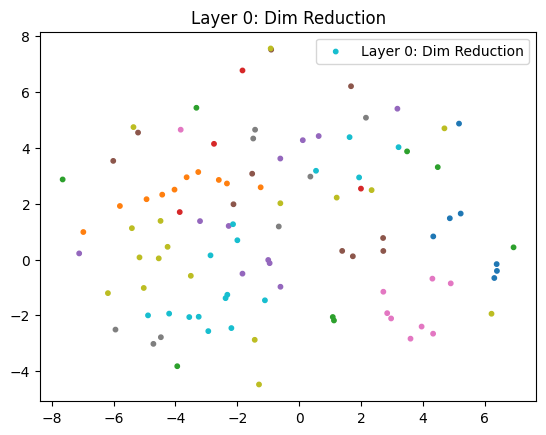

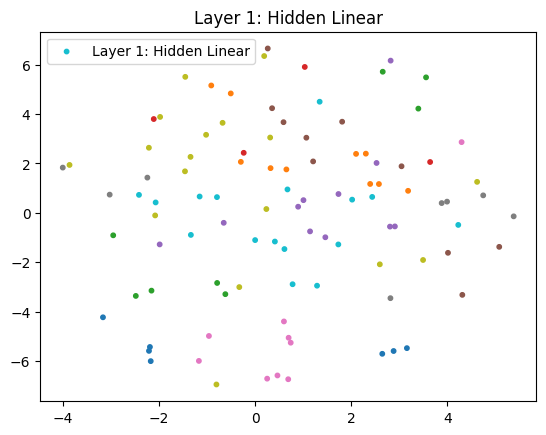

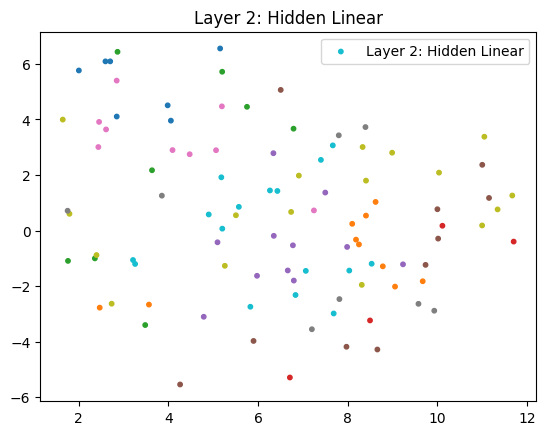

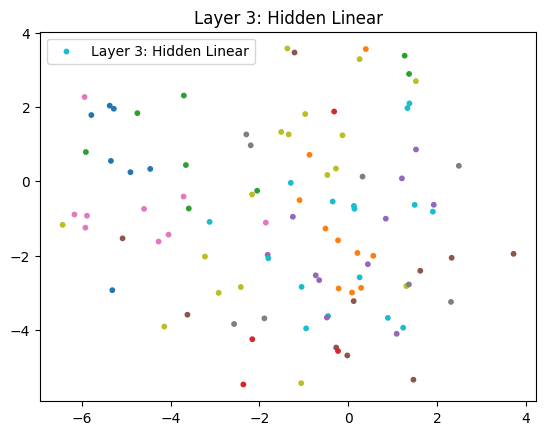

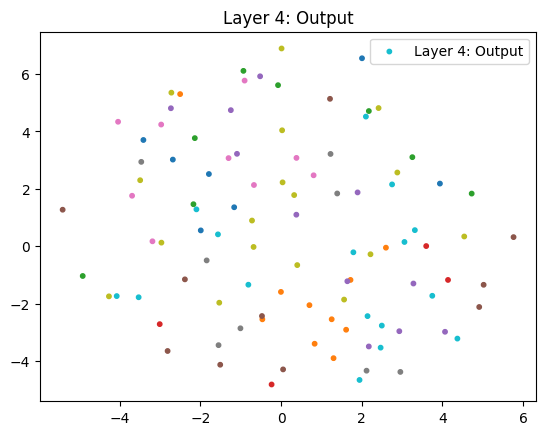

In [9]:
#reducer = PCA(n_components=2)
all_reduced = {}
#We don't use all activations so that it doesn't take 15 minutes to process, this way we can run tests

for layer_name, acts in activations.items():
    cur_acts = acts.cpu().numpy()[:100]
    cur_acts = cur_acts.reshape(cur_acts.shape[0], -1)
    reducer = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
    reduced_activations = reducer.fit_transform(cur_acts)
    all_reduced[layer_name] = reduced_activations
    plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], c=true_labels.cpu().numpy()[:100], cmap="tab10", s=10, label=layer_name)
    plt.title(layer_name)
    plt.legend()
    plt.show()